In [99]:
import os
import json
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression
import GPy

from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [100]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.4 # beautification
    
# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 80

In [101]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=0.25)

    return ax

In [102]:
def gp_creator(x, y, val = 5):
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

{'dataplot': [<matplotlib.collections.PathCollection at 0x7ff83b0f8ac8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7ff83b501ac8>]],
 'gpdensity': [[<matplotlib.collections.PolyCollection at 0x7ff83b081048>]]}

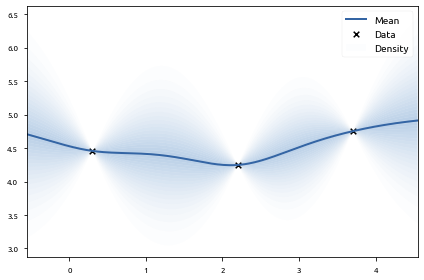

In [103]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

nnsvm(plt.rcParams, -2)
x = np.atleast_2d(np.linspace(0, 6, 100000)).T
y_pred, sigma = 5*np.ones(x.shape).flatten(), 1.1*np.ones(x.shape).flatten()

train_X = np.array([[.3],[2.2], [3.7]])
train_y = f(train_X)

gp = gp_creator(train_X, train_y)
mu, var = gp.predict(x)
mu = mu.squeeze()
std = np.sqrt(var).squeeze()
x = x.flatten()
gp.plot(plot_density=True)


In [104]:
def plot_gray(n):
    y1 = mu-n*std
    y2 = mu+n*std
    y_temp = y_max_eps*np.ones_like(y1)
    plt.fill_between(
        x,y2,y1,where=y1>=y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, label=labels[n], linewidth=0
    )
    plt.fill_between(
        x,y2,y_temp,where=y2>=y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    plt.fill_between(
        x,y2,y1,where=y2<=y_temp,
        color='black',alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    plt.fill_between(
        x,y1,y_temp, where=y2>=y_temp,
        color='black',alpha=alphas[n],
        interpolate=False, linewidth=0
    )


In [107]:
nnsvm(plt.rcParams, 4)

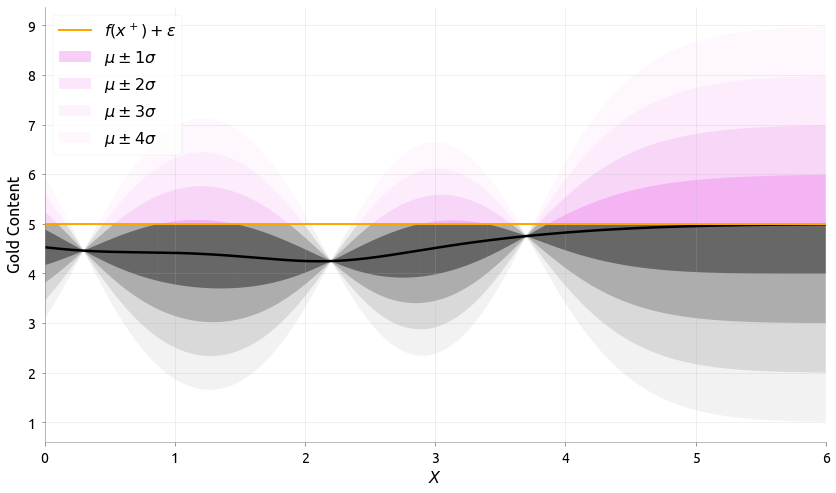

In [108]:
y_max_eps = mu.max()

plt.figure(figsize=(14, 8))
plt.plot(x, mu, color='k', mew=2, lw=2.5)

alphas = {1:0.4, 2:0.2, 3:0.1, 4:0.05}
labels = {x:r'$\mu \pm %s\sigma$' %x for x in [1, 2, 3, 4]}

plot_gray(1)
plot_gray(2)
plot_gray(3)
plot_gray(4)

plt.axhline(y_max_eps, color='orange', mew=2, lw=2, label=r'$f(x^+) + \epsilon$')

plt.legend(loc='upper left')
plt.xlabel("$X$")
plt.ylabel(r"Gold Content")
plt.xlim((x.min(), x.max()))
format_axes(plt.gca())
plt.savefig("MAB_gifs/density_pi.svg", bbox_inches="tight")

# Explaining Probability of Improvement
> From the ground up!

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [1]:
from math import sqrt
SPINE_COLOR = 'gray'

In [2]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

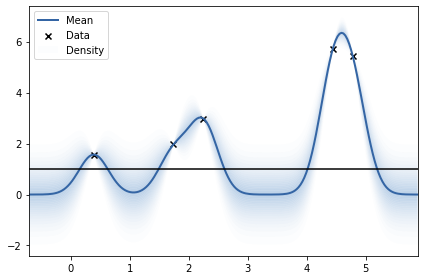

In [4]:
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2

np.random.seed(0)
# 30 equally spaced sample locations 
X = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X)

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

train_X = X[:5]
train_Y = Y[:5]

test_X = X[5:]
test_Y = Y[5:]




ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error


iteration = 1

k = GPy.kern.RBF(1)
k.lengthscale = ls[iteration]
m = GPy.models.GPRegression(train_X, train_Y, k)
m.Gaussian_noise = 0.0
m.plot(plot_density=True)
plt.axhline(1, color='k')


In [26]:
X2  = np.linspace(0.05, 4.95, 10000)[:,None]
mu, var = m.predict(X2)
mu = mu.squeeze()
std = np.sqrt(var).squeeze()
x = X2.flatten()

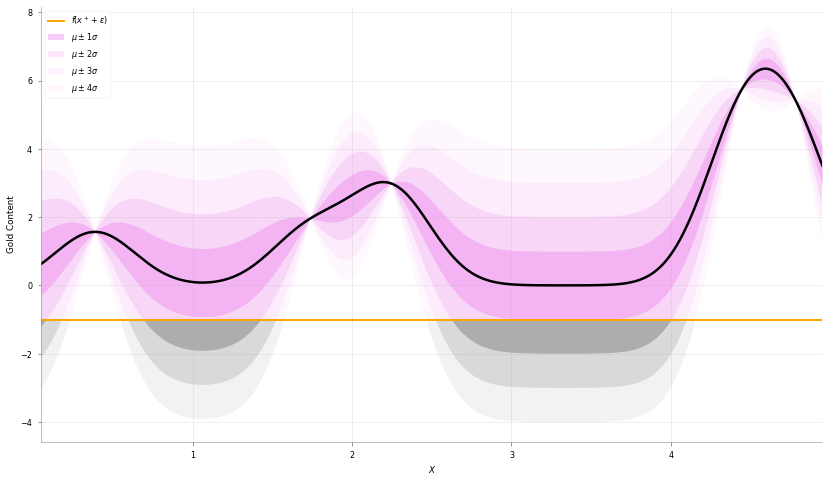

In [18]:
# latexify(fig_width=5)
y_max_eps = -1

plt.figure(figsize=(14, 8))
plt.plot(X2, mu, color='k', mew=2, lw=2.5)
alphas = {1:0.4, 2:0.2, 3:0.1, 4:0.05}
labels = {x:r'$\mu \pm %s\sigma$' %x for x in [1, 2, 3, 4]}
def plot_gray(n):
    y1 = mu-n*std
    y2 = mu+n*std
    y_temp = y_max_eps*np.ones_like(y1)
    plt.fill_between(
        x,y1,y2,where=y1>y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, label=labels[n], linewidth=0
    )
    plt.fill_between(
        x,y_temp,y2,where=y1<=y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    plt.fill_between(
        x,y1,y_temp,where=y1<=y_temp,
        color='black', alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    #plt.fill_between(x,y1,y_temp,where=y1<=y_temp,color='black', alpha=1, interpolate=True)



plot_gray(1)

plot_gray(2)
plot_gray(3)
plot_gray(4)




plt.axhline(y_max_eps, color='orange', mew=2, lw=2, label=r'$f(x^+ + \epsilon)$')

plt.legend(loc='upper left')
plt.xlabel("$X$")
plt.ylabel(r"Gold Content")
plt.xlim((x.min(), x.max()))
format_axes(plt.gca())